In [1]:
import numpy as np
import os
import librosa
import librosa.display
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.preprocessing
from scipy.signal import lfilter
from joblib import Parallel, delayed
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, classification_report

In [2]:
df = pd.read_csv(r"C:\Users\sakshi\Desktop\SMLProject\bin_labeled_w_audio_path.csv")

In [3]:
clip_path = r"C:\Users\sakshi\Desktop\SMLProject\DatasetExtraction\extracted_clips"

In [4]:
value_counts = df['Stutter'].value_counts()
total_rows = df.shape[0]

percentage_per_class = (value_counts / total_rows) * 100

print(percentage_per_class)

Stutter
0    60.677123
1    39.322877
Name: count, dtype: float64


In [5]:
def extract_mfcc(audio_file, num_mfcc=40):
    audio, sr = librosa.load(audio_file, sr=None)
    mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=num_mfcc)
    mfccs_transposed = mfccs.T  # Transpose the MFCC matrix
    mfccs_flat = mfccs_transposed.flatten()  # Flatten the transposed MFCC matrix
    return mfccs_flat

In [6]:
def extract_zcr(audio_file, frame_length=2048, hop_length=512):
    audio, sr = librosa.load(audio_file, sr=None)
    zcr = librosa.feature.zero_crossing_rate(audio, frame_length=frame_length, hop_length=hop_length)
    return zcr.flatten()

In [7]:
def calculate_jitter(audio_file, frame_length=2048, hop_length=512):
    y, sr = librosa.load(audio_file, sr=None)
    f0, voiced_flag, voiced_probs = librosa.pyin(y, fmin=75, fmax=600)
    periods = 1 / f0[voiced_flag]
    periods[np.isnan(periods)] = 0
    period_diffs = np.diff(periods)
    jitter = np.mean(np.abs(period_diffs)) * 100 
    return jitter

In [8]:
def calculate_shimmer(audio_file, frame_length=2048, hop_length=512):
    y, sr = librosa.load(audio_file, sr=None)
    f0, voiced_flag, _ = librosa.pyin(y, fmin=75, fmax=600)
    rms = librosa.feature.rms(y=y, frame_length=frame_length, hop_length=hop_length)[0]
    voiced_rms = rms[voiced_flag]
    voiced_rms[np.isnan(voiced_rms)] = 0
    shimmer = np.mean(np.abs(np.diff(voiced_rms))) / np.mean(voiced_rms) * 100
    return shimmer

In [9]:
def merge_features(mfcc, zcr, jitter, shimmer):
    return np.hstack((mfcc, zcr, jitter, shimmer))

In [10]:
audio_files = df['audio_path'] 
labels = df['Prolongation']

In [11]:
df_prolongation = df[['audio_path', 'Prolongation']]

In [12]:
df_prolongation

,audio_path,Prolongation
0,C:\Users\sakshi\Desktop\SMLProject\DatasetExtr...,0
1,C:\Users\sakshi\Desktop\SMLProject\DatasetExtr...,0
2,C:\Users\sakshi\Desktop\SMLProject\DatasetExtr...,0
3,C:\Users\sakshi\Desktop\SMLProject\DatasetExtr...,0
4,C:\Users\sakshi\Desktop\SMLProject\DatasetExtr...,0
...,...,...
19696,C:\Users\sakshi\Desktop\SMLProject\DatasetExtr...,0
19697,C:\Users\sakshi\Desktop\SMLProject\DatasetExtr...,0
19698,C:\Users\sakshi\Desktop\SMLProject\DatasetExtr...,0
19699,C:\Users\sakshi\Desktop\SMLProject\DatasetExtr...,0


In [13]:
df['Prolongation'].value_counts()

Prolongation
0    17636
1     2065
Name: count, dtype: int64

In [14]:
df_prolongation_1 = df_prolongation[df_prolongation['Prolongation']==1]

In [15]:
df_prolongation_0 = df[(df['Prolongation']==0) & 
                        (df['Block']==0) & 
                        (df['Interjection']==0) & 
                        (df['WordRep']==0) & 
                        (df['SoundRep']==0) &
                        (df['NoStutteredWords']==1)]

In [16]:
df_prolongation_1.shape

(2065, 2)

In [17]:
df_prolongation_0_sampled = df_prolongation_0.sample(df_prolongation_1.shape[0])

In [18]:
df_prolongation_0_sampled.shape

(2065, 20)

In [19]:
df_prolongation_data = pd.concat([df_prolongation_0_sampled, df_prolongation_1], ignore_index=True, axis=0)

In [20]:
df_prolongation_data.shape

(4130, 20)

In [21]:
df_prolongation_data.head()

,Unnamed: 0.2,Unnamed: 0.1,Unnamed: 0,Show,EpId,ClipId,Start,Stop,Prolongation,Block,SoundRep,WordRep,Interjection,NoStutteredWords,NaturalPause,NoSpeech,audio_path,Label,audio_length,Stutter
0,18298.0,20335.0,26656.0,WomenWhoStutter,92.0,28.0,34187040.0,34235040.0,0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,C:\Users\sakshi\Desktop\SMLProject\DatasetExtr...,NaN,48000.0,0.0
1,455.0,546.0,546.0,HeStutters,3.0,17.0,20033760.0,20081760.0,0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,C:\Users\sakshi\Desktop\SMLProject\DatasetExtr...,NaN,48000.0,0.0
2,9337.0,10320.0,12628.0,StutterTalk,43.0,11.0,61300480.0,61348480.0,0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,C:\Users\sakshi\Desktop\SMLProject\DatasetExtr...,NaN,48000.0,0.0
3,11089.0,12219.0,14527.0,StutterTalk,72.0,87.0,10928640.0,10976640.0,0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,C:\Users\sakshi\Desktop\SMLProject\DatasetExtr...,NaN,48000.0,0.0
4,12295.0,13623.0,19944.0,WomenWhoStutter,6.0,119.0,2137440.0,2185440.0,0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,C:\Users\sakshi\Desktop\SMLProject\DatasetExtr...,NaN,48000.0,0.0


In [23]:
df_prolongation_data.drop(['Unnamed: 0.2','Unnamed: 0.1','Unnamed: 0'],axis=1,inplace=True)

In [24]:
value_counts = df_prolongation_data['Prolongation'].value_counts()
total_rows = df_prolongation_data.shape[0]

percentage_per_class = (value_counts / total_rows) * 100

print(percentage_per_class)

Prolongation
0    50.0
1    50.0
Name: count, dtype: float64


In [26]:
X = np.array(df_prolongation_data['audio_path'])
y = np.array(df_prolongation_data['Prolongation'])

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=40, stratify = y)

In [28]:
train_temp_df = pd.DataFrame()

In [29]:
# Extract MFCC features for training set
train_temp_df['mfcc'] = Parallel(n_jobs=-1)(delayed(extract_mfcc)(audio_file) for audio_file in X_train)

# Extract ZCR features for training set
train_temp_df['zcr'] = Parallel(n_jobs=-1)(delayed(extract_zcr)(audio_file) for audio_file in X_train)

# Extract Jitter features for training set
train_temp_df['jitter'] = Parallel(n_jobs=-1)(delayed(calculate_jitter)(audio_file) for audio_file in X_train)

# Replace NaN values in Jitter column with zero for training set
train_temp_df['jitter'] = train_temp_df['jitter'].fillna(0)

# Extract Shimmer features for training set
train_temp_df['shimmer'] = Parallel(n_jobs=-1)(delayed(calculate_shimmer)(audio_file) for audio_file in X_train)

# Replace NaN values in Shimmer column with zero for training set
train_temp_df['shimmer'] = train_temp_df['shimmer'].fillna(0)

In [30]:
train_temp_df.isna().sum()

mfcc       0
zcr        0
jitter     0
shimmer    0
dtype: int64

In [31]:
mfcc_features_train = np.array(train_temp_df['mfcc'])
zcr_features_train = np.array(train_temp_df['zcr'])
jitter_features_train = np.array(train_temp_df['jitter'])
shimmer_features_train = np.array(train_temp_df['shimmer'])

In [32]:
merged_features_train = [merge_features(mfcc, zcr, jitter, shimmer) for mfcc, zcr, jitter, shimmer in zip(mfcc_features_train, zcr_features_train, jitter_features_train, shimmer_features_train)]

In [33]:
merged_features_train

[array([-5.77527893e+02, -1.33375473e+01,  6.25851536e+00, ...,
         3.12500000e-02,  3.18565343e-02,  1.56339750e+01]),
 array([-1.73955841e+02,  3.43662338e+01,  6.11304712e+00, ...,
         8.49609375e-02,  1.10148932e-02,  1.44385085e+01]),
 array([-2.50678818e+02,  1.10124664e+02,  3.26077957e+01, ...,
         6.34765625e-02,  1.29674647e-02,  1.23009160e+01]),
 array([-6.09596313e+02,  3.80950928e+01,  2.19912109e+01, ...,
         1.41113281e-01,  1.88549504e-02,  2.33311996e+01]),
 array([-4.74027649e+02,  7.02176743e+01,  4.53257179e+00, ...,
         2.68554688e-01,  1.50230014e-02,  3.21851760e+01]),
 array([-1.54225479e+02,  1.12640793e+02,  1.24409370e+01, ...,
         1.57226562e-01,  1.41888092e-02,  1.89927235e+01]),
 array([-2.52046188e+02,  7.26609192e+01, -1.71191940e+01, ...,
         7.32421875e-02,  7.54464201e-03,  1.49818450e+01]),
 array([-6.32839050e+02,  4.31729507e+01,  2.33651085e+01, ...,
         8.78906250e-02,  1.21332607e-02,  1.72803700e+01]),


In [34]:
print("Shape of merged_features_train:", np.array(merged_features_train).shape)

Shape of merged_features_train: (2891, 3856)


In [35]:
test_temp_df = pd.DataFrame()

In [37]:
# Extract MFCC features for testing set
test_temp_df['mfcc'] = Parallel(n_jobs=-1)(delayed(extract_mfcc)(audio_file) for audio_file in X_test)

# Extract ZCR features for testing set
test_temp_df['zcr'] = Parallel(n_jobs=-1)(delayed(extract_zcr)(audio_file) for audio_file in X_test)

# Extract Jitter features for testing set
test_temp_df['jitter'] = Parallel(n_jobs=-1)(delayed(calculate_jitter)(audio_file) for audio_file in X_test)

# Replace NaN values in Jitter column with zero for testing set
test_temp_df['jitter'] = test_temp_df['jitter'].fillna(0)

# Extract Shimmer features for testing set
test_temp_df['shimmer'] = Parallel(n_jobs=-1)(delayed(calculate_shimmer)(audio_file) for audio_file in X_test)

# Replace NaN values in Shimmer column with zero for testing set
test_temp_df['shimmer'] = test_temp_df['shimmer'].fillna(0)

In [38]:
test_temp_df.isna().sum()

mfcc       0
zcr        0
jitter     0
shimmer    0
dtype: int64

In [39]:
# Convert testing dataframe to arrays
mfcc_features_test = np.array(test_temp_df['mfcc'])
zcr_features_test = np.array(test_temp_df['zcr'])
jitter_features_test = np.array(test_temp_df['jitter'])
shimmer_features_test = np.array(test_temp_df['shimmer'])

In [40]:
merged_features_test = [merge_features(mfcc, zcr, jitter, shimmer) for mfcc, zcr, jitter, shimmer in zip(mfcc_features_test, zcr_features_test, jitter_features_test, shimmer_features_test)]

In [41]:
print("Shape of merged_features_test:", np.array(merged_features_test).shape)

Shape of merged_features_test: (1239, 3856)


In [42]:
y_train_series = pd.Series(y_train)
y_test_series = pd.Series(y_test)

# Count the occurrences of each unique value in y_train
train_distribution = y_train_series.value_counts()

# Count the occurrences of each unique value in y_test
test_distribution = y_test_series.value_counts()

print("Distribution of 0s and 1s in y_train:")
print(train_distribution)

print("\nDistribution of 0s and 1s in y_test:")
print(test_distribution)

Distribution of 0s and 1s in y_train:
1    1446
0    1445
Name: count, dtype: int64

Distribution of 0s and 1s in y_test:
0    620
1    619
Name: count, dtype: int64


# Random Forest

### Searching for best parameter

In [43]:
param_grid_rf = {
    'n_estimators': [100, 300, 500, 800],
    'max_depth': [5, 10, 15, 20],
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 2, 4, 6, 10]
}

In [44]:
rf = RandomForestClassifier(random_state=42, n_jobs=-1)

In [45]:
random_search_rf = RandomizedSearchCV(estimator=rf, param_distributions=param_grid_rf, n_iter=50, cv=5, random_state=42)

In [46]:
random_search_rf.fit(merged_features_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=RandomForestClassifier(n_jobs=-1, random_state=42),
                   n_iter=50,
                   param_distributions={'max_depth': [5, 10, 15, 20],
                                        'min_samples_leaf': [1, 2, 4, 6, 10],
                                        'min_samples_split': [2, 5, 10, 20],
                                        'n_estimators': [100, 300, 500, 800]},
                   random_state=42)

In [47]:
best_params_rf = random_search_rf.best_params_
best_model_rf = random_search_rf.best_estimator_

print("Best parameters (Random Forest):", best_params_rf)

print(f"Best score (Random Forest): {random_search_rf.best_score_*100:.4f}%")

Best parameters (Random Forest): {'n_estimators': 800, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_depth': 10}
Best score (Random Forest): 65.6508%


#### Evaluate the best model

In [48]:
from sklearn.metrics import roc_curve, auc
def plot_roc(best_model, model_name):
    predicted_probabilities = best_model.predict_proba(merged_features_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, predicted_probabilities)
    roc_auc = auc(fpr, tpr)
    
    # Plot ROC curve
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Prolongation - {model_name} - ROC Curve')
    plt.legend(loc="lower right")
    plt.savefig(f'ROC_Prolongation_{model_name}.png')
    plt.show()

In [49]:
y_pred_rf = best_model_rf.predict(merged_features_test)

In [50]:
accuracy_score(y_test,y_pred_rf)

0.6577885391444713

In [51]:
print(classification_report(y_test, y_pred_rf))

              precision    recall  f1-score   support

           0       0.64      0.71      0.68       620
           1       0.68      0.60      0.64       619

    accuracy                           0.66      1239
   macro avg       0.66      0.66      0.66      1239
weighted avg       0.66      0.66      0.66      1239



In [53]:
best_model_rf = RandomForestClassifier(n_jobs=-1, n_estimators=800, min_samples_split=5, min_samples_leaf=4, max_depth=10)
best_model_rf.fit(merged_features_train, y_train)

RandomForestClassifier(max_depth=10, min_samples_leaf=4, min_samples_split=5,
                       n_estimators=800, n_jobs=-1)

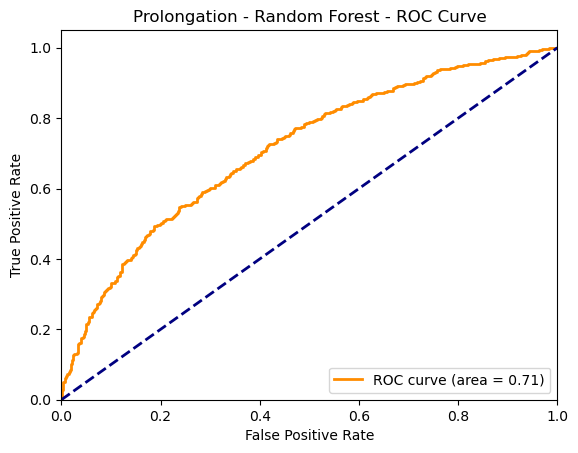

In [54]:
plot_roc(best_model_rf, 'Random Forest')

In [55]:
verifyer_rf = pd.DataFrame([X_test, y_pred_rf, y_test]).T

In [56]:
verifyer_rf.columns = ['audio', 'y_pred', 'y_test']

In [57]:
verifyer_rf[(verifyer_rf['y_pred']==0) & (verifyer_rf['y_test']==0)]

,audio,y_pred,y_test
1,C:\Users\sakshi\Desktop\SMLProject\DatasetExtr...,0,0
4,C:\Users\sakshi\Desktop\SMLProject\DatasetExtr...,0,0
5,C:\Users\sakshi\Desktop\SMLProject\DatasetExtr...,0,0
12,C:\Users\sakshi\Desktop\SMLProject\DatasetExtr...,0,0
16,C:\Users\sakshi\Desktop\SMLProject\DatasetExtr...,0,0
...,...,...,...
1229,C:\Users\sakshi\Desktop\SMLProject\DatasetExtr...,0,0
1232,C:\Users\sakshi\Desktop\SMLProject\DatasetExtr...,0,0
1233,C:\Users\sakshi\Desktop\SMLProject\DatasetExtr...,0,0
1236,C:\Users\sakshi\Desktop\SMLProject\DatasetExtr...,0,0


In [58]:
verifyer_rf[(verifyer_rf['y_pred']==1) & (verifyer_rf['y_test']==1)]

,audio,y_pred,y_test
0,C:\Users\sakshi\Desktop\SMLProject\DatasetExtr...,1,1
2,C:\Users\sakshi\Desktop\SMLProject\DatasetExtr...,1,1
7,C:\Users\sakshi\Desktop\SMLProject\DatasetExtr...,1,1
9,C:\Users\sakshi\Desktop\SMLProject\DatasetExtr...,1,1
14,C:\Users\sakshi\Desktop\SMLProject\DatasetExtr...,1,1
...,...,...,...
1228,C:\Users\sakshi\Desktop\SMLProject\DatasetExtr...,1,1
1230,C:\Users\sakshi\Desktop\SMLProject\DatasetExtr...,1,1
1231,C:\Users\sakshi\Desktop\SMLProject\DatasetExtr...,1,1
1235,C:\Users\sakshi\Desktop\SMLProject\DatasetExtr...,1,1


In [59]:
verifyer_rf

,audio,y_pred,y_test
0,C:\Users\sakshi\Desktop\SMLProject\DatasetExtr...,1,1
1,C:\Users\sakshi\Desktop\SMLProject\DatasetExtr...,0,0
2,C:\Users\sakshi\Desktop\SMLProject\DatasetExtr...,1,1
3,C:\Users\sakshi\Desktop\SMLProject\DatasetExtr...,0,1
4,C:\Users\sakshi\Desktop\SMLProject\DatasetExtr...,0,0
...,...,...,...
1234,C:\Users\sakshi\Desktop\SMLProject\DatasetExtr...,1,0
1235,C:\Users\sakshi\Desktop\SMLProject\DatasetExtr...,1,1
1236,C:\Users\sakshi\Desktop\SMLProject\DatasetExtr...,0,0
1237,C:\Users\sakshi\Desktop\SMLProject\DatasetExtr...,1,1


In [60]:
verifyer_rf.to_csv("predicted_randomforest_prolongation.csv")

In [61]:
import pickle
file_path = "randomforest_Prolongation.pkl"

with open(file_path, 'wb') as file:
    pickle.dump(best_model_rf, file)

In [62]:
test_rf = pd.DataFrame([X_test, y_test, y_pred_rf]).T
test_rf.columns = ['X_test', 'y_test', 'y_pred']

In [63]:
test_rf.to_csv("test_rf_prolongation.csv")

# Decision Tree

In [64]:
param_grid_dt = {
    'max_depth': [5, 10, 15, 20],
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 2, 4, 6, 10]
}

In [65]:
dt = DecisionTreeClassifier(random_state=42)
random_search_dt = RandomizedSearchCV(estimator=dt, param_distributions=param_grid_dt, n_iter=50, cv=5, random_state=42)

In [66]:
random_search_dt.fit(merged_features_train, y_train)

RandomizedSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=42),
                   n_iter=50,
                   param_distributions={'max_depth': [5, 10, 15, 20],
                                        'min_samples_leaf': [1, 2, 4, 6, 10],
                                        'min_samples_split': [2, 5, 10, 20]},
                   random_state=42)

In [67]:
best_params_dt = random_search_dt.best_params_
best_model_dt = random_search_dt.best_estimator_

print("Best parameters (Decision Tree):", best_params_dt)

print(f"Best score (Decision Tree): {random_search_dt.best_score_*100:.4f}%")

Best parameters (Decision Tree): {'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 5}
Best score (Decision Tree): 58.0423%


In [68]:
y_pred_dt = best_model_dt.predict(merged_features_test)

In [69]:
accuracy_score(y_test, y_pred_dt)

0.5754640839386602

In [70]:
print(classification_report(y_test, y_pred_dt))

              precision    recall  f1-score   support

           0       0.56      0.69      0.62       620
           1       0.60      0.46      0.52       619

    accuracy                           0.58      1239
   macro avg       0.58      0.58      0.57      1239
weighted avg       0.58      0.58      0.57      1239



In [71]:
best_model_dt = DecisionTreeClassifier(min_samples_split=2, min_samples_leaf=1, max_depth=5)
best_model_dt.fit(merged_features_train, y_train)

DecisionTreeClassifier(max_depth=5)

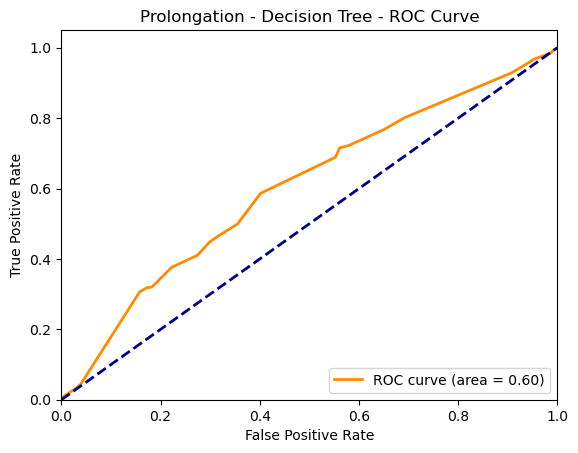

In [72]:
plot_roc(best_model_dt,'Decision Tree')

In [73]:
file_path = "decisiontree_Prolongation.pkl"

with open(file_path, 'wb') as file:
    pickle.dump(best_model_dt, file)

In [74]:
verifyer_dt = pd.DataFrame([X_test, y_pred_dt, y_test]).T
verifyer_dt.columns = ['audio', 'y_pred', 'y_test']
verifyer_dt.to_csv("predicted_dt_prolongation.csv")
test_dt = pd.DataFrame([X_test, y_test, y_pred_dt]).T
test_dt.columns = ['X_test', 'y_test', 'y_pred']
test_dt.to_csv("test_dt_prolongation.csv")

# KNN

In [75]:
param_grid_knn = {
    'n_neighbors': np.arange(1, 22, 2),
    'weights': ['uniform', 'distance'],
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
    'p': [1, 2]
}

In [76]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_jobs=-1)
random_search_knn = RandomizedSearchCV(estimator=knn, param_distributions=param_grid_knn, n_iter=50, cv=5, random_state=42)

In [77]:
random_search_knn.fit(merged_features_train, y_train)

RandomizedSearchCV(cv=5, estimator=KNeighborsClassifier(n_jobs=-1), n_iter=50,
                   param_distributions={'algorithm': ['auto', 'ball_tree',
                                                      'kd_tree', 'brute'],
                                        'n_neighbors': array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19, 21]),
                                        'p': [1, 2],
                                        'weights': ['uniform', 'distance']},
                   random_state=42)

In [78]:
best_params_knn = random_search_knn.best_params_
best_model_knn = random_search_knn.best_estimator_

print("Best parameters (KNN):", best_params_knn)

print(f"Best score (KNN): {random_search_knn.best_score_*100:.4f}%")

Best parameters (KNN): {'weights': 'distance', 'p': 1, 'n_neighbors': 21, 'algorithm': 'auto'}
Best score (KNN): 62.4356%


In [79]:
y_pred_knn = best_model_knn.predict(merged_features_test)

In [80]:
accuracy_score(y_test, y_pred_knn)

0.6045197740112994

In [81]:
print(classification_report(y_test, y_pred_knn))

              precision    recall  f1-score   support

           0       0.61      0.59      0.60       620
           1       0.60      0.62      0.61       619

    accuracy                           0.60      1239
   macro avg       0.60      0.60      0.60      1239
weighted avg       0.60      0.60      0.60      1239



In [82]:
best_model_knn = KNeighborsClassifier(n_jobs=-1, weights='distance', p=1, n_neighbors=21, algorithm='auto')
best_model_knn.fit(merged_features_train, y_train)

KNeighborsClassifier(n_jobs=-1, n_neighbors=21, p=1, weights='distance')

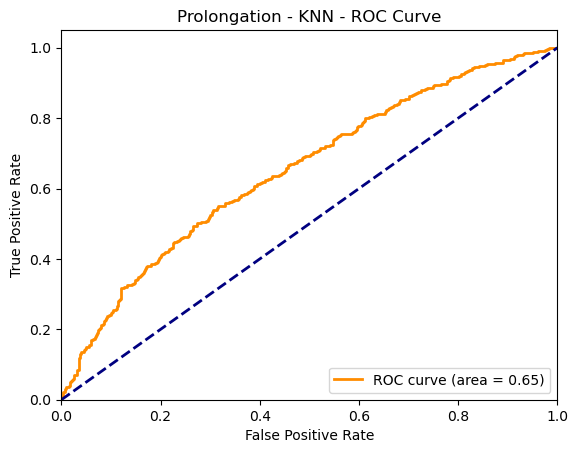

In [83]:
plot_roc(best_model_knn, 'KNN')

In [84]:
file_path = "knn_Prolongation.pkl"

with open(file_path, 'wb') as file:
    pickle.dump(best_model_knn, file)

In [85]:
verifyer_knn = pd.DataFrame([X_test, y_pred_knn, y_test]).T
verifyer_knn.columns = ['audio', 'y_pred', 'y_test']
verifyer_knn.to_csv("predicted_knn_prolongation.csv")
test_knn = pd.DataFrame([X_test, y_test, y_pred_knn]).T
test_knn.columns = ['X_test', 'y_test', 'y_pred']
test_knn.to_csv("test_knn_prolongation.csv")

# SVM

In [86]:
param_grid_svc = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'gamma': ['scale', 'auto']
}

In [89]:
svc = SVC()
random_search_svc = RandomizedSearchCV(estimator=svc, param_distributions=param_grid_svc, n_iter=32, cv=5, random_state=42)

In [90]:
random_search_svc.fit(merged_features_train, y_train)

RandomizedSearchCV(cv=5, estimator=SVC(), n_iter=32,
                   param_distributions={'C': [0.1, 1, 10, 100],
                                        'gamma': ['scale', 'auto'],
                                        'kernel': ['linear', 'poly', 'rbf',
                                                   'sigmoid']},
                   random_state=42)

In [91]:
best_params_svc = random_search_svc.best_params_
best_model_svc = random_search_svc.best_estimator_

print("Best parameters (SVC):", best_params_svc)

print(f"Best score (SVC): {random_search_svc.best_score_*100:.4f}%")

Best parameters (SVC): {'kernel': 'rbf', 'gamma': 'scale', 'C': 10}
Best score (SVC): 63.5411%


In [92]:
y_pred_svc = best_model_svc.predict(merged_features_test)

In [93]:
accuracy_score(y_test, y_pred_svc)

0.6287328490718321

In [94]:
print(classification_report(y_test, y_pred_svc))

              precision    recall  f1-score   support

           0       0.63      0.61      0.62       620
           1       0.62      0.65      0.64       619

    accuracy                           0.63      1239
   macro avg       0.63      0.63      0.63      1239
weighted avg       0.63      0.63      0.63      1239



In [95]:
best_model_svc = SVC(kernel='rbf', gamma='scale', C=10, probability=True)
best_model_svc.fit(merged_features_train, y_train)

SVC(C=10, probability=True)

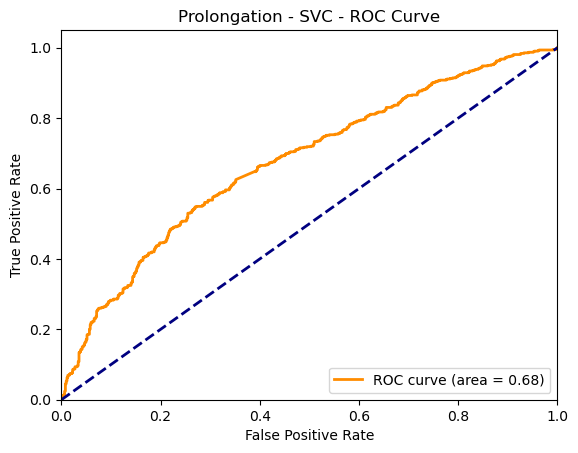

In [96]:
plot_roc(best_model_svc, 'SVC')

In [97]:
file_path = "svc_Prolongation.pkl"

with open(file_path, 'wb') as file:
    pickle.dump(best_model_svc, file)

In [98]:
verifyer_svc = pd.DataFrame([X_test, y_pred_svc, y_test]).T
verifyer_svc.columns = ['audio', 'y_pred', 'y_test']
verifyer_svc.to_csv("predicted_svc_prolongation.csv")
test_svc = pd.DataFrame([X_test, y_test, y_pred_svc]).T
test_svc.columns = ['X_test', 'y_test', 'y_pred']
test_svc.to_csv("test_svc_prolongation.csv")

# Naive Bayes

In [101]:
from sklearn.model_selection import cross_validate
from sklearn.naive_bayes import GaussianNB
nb = GaussianNB()

In [102]:
# Perform cross-validation
cv_results = cross_validate(nb, merged_features_train, y_train, cv=10,
                            scoring=['accuracy', 'precision', 'recall', 'f1'],
                            return_estimator=True)

In [103]:
cv_results

{'fit_time': array([0.186095  , 0.18709826, 0.1823802 , 0.20356393, 0.2091043 ,
        0.18766141, 0.19471908, 0.18765688, 0.16528726, 0.1896615 ]),
 'score_time': array([0.04569483, 0.03764153, 0.03124452, 0.03124928, 0.02212763,
        0.05540013, 0.03118515, 0.03118014, 0.03623939, 0.03169799]),
 'estimator': [GaussianNB(),
  GaussianNB(),
  GaussianNB(),
  GaussianNB(),
  GaussianNB(),
  GaussianNB(),
  GaussianNB(),
  GaussianNB(),
  GaussianNB(),
  GaussianNB()],
 'test_accuracy': array([0.55517241, 0.61591696, 0.64705882, 0.57093426, 0.53979239,
        0.60553633, 0.58823529, 0.56747405, 0.53979239, 0.56401384]),
 'test_precision': array([0.55970149, 0.61038961, 0.64827586, 0.57342657, 0.54545455,
        0.624     , 0.58278146, 0.56737589, 0.54471545, 0.56617647]),
 'test_recall': array([0.51724138, 0.64827586, 0.64827586, 0.56551724, 0.49655172,
        0.53793103, 0.61111111, 0.55555556, 0.46527778, 0.53472222]),
 'test_f1': array([0.53763441, 0.62876254, 0.64827586, 0.569

In [104]:
# Extract the best model based on accuracy
best_model_index = cv_results['test_accuracy'].argmax()
best_model_nb = cv_results['estimator'][best_model_index]

In [105]:
best_model_index

2

In [106]:
best_model_nb.fit(merged_features_train, y_train)

GaussianNB()

In [107]:
y_pred_nb = best_model_nb.predict(merged_features_test)

In [108]:
accuracy_score(y_test, y_pred_nb)

0.5980629539951574

In [109]:
print(classification_report(y_test, y_pred_nb))

              precision    recall  f1-score   support

           0       0.60      0.61      0.60       620
           1       0.60      0.58      0.59       619

    accuracy                           0.60      1239
   macro avg       0.60      0.60      0.60      1239
weighted avg       0.60      0.60      0.60      1239



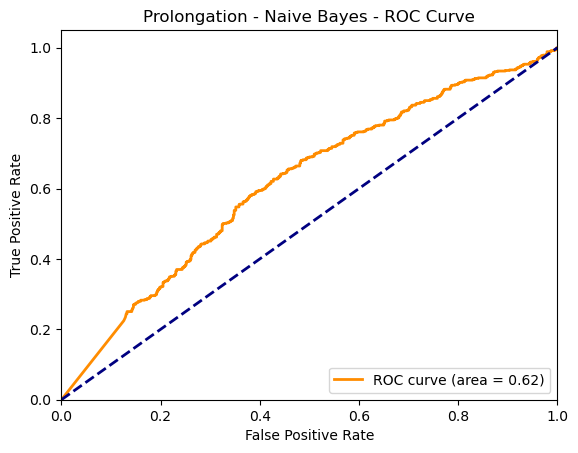

In [110]:
plot_roc(best_model_nb, 'Naive Bayes')

In [111]:
file_path = "naivebayes_Prolongation.pkl"

with open(file_path, 'wb') as file:
    pickle.dump(best_model_nb, file)

In [112]:
verifyer_nb = pd.DataFrame([X_test, y_pred_nb, y_test]).T
verifyer_nb.columns = ['audio', 'y_pred', 'y_test']
verifyer_nb.to_csv("predicted_nb_prolongation.csv")
test_nb = pd.DataFrame([X_test, y_test, y_pred_nb]).T
test_nb.columns = ['X_test', 'y_test', 'y_pred']
test_nb.to_csv("test_nb_prolongation.csv")

# Logistic Regression

In [113]:
lr = LogisticRegression(n_jobs=-1)

In [114]:
# Perform cross-validation
cv_results_1= cross_validate(lr, merged_features_train, y_train, cv=10,
                            scoring=['accuracy', 'precision', 'recall', 'f1'],
                            return_estimator=True)

In [115]:
cv_results_1

{'fit_time': array([7.28140163, 2.78112078, 2.64065504, 2.43764019, 2.6684556 ,
        2.76599073, 2.7383852 , 2.70932627, 2.41272354, 2.34076619]),
 'score_time': array([0.01552272, 0.01563239, 0.        , 0.01567268, 0.01603532,
        0.00262022, 0.01201534, 0.0100522 , 0.0156424 , 0.00652623]),
 'estimator': [LogisticRegression(n_jobs=-1),
  LogisticRegression(n_jobs=-1),
  LogisticRegression(n_jobs=-1),
  LogisticRegression(n_jobs=-1),
  LogisticRegression(n_jobs=-1),
  LogisticRegression(n_jobs=-1),
  LogisticRegression(n_jobs=-1),
  LogisticRegression(n_jobs=-1),
  LogisticRegression(n_jobs=-1),
  LogisticRegression(n_jobs=-1)],
 'test_accuracy': array([0.55517241, 0.5916955 , 0.56055363, 0.53979239, 0.56401384,
        0.51903114, 0.57093426, 0.57093426, 0.5432526 , 0.57093426]),
 'test_precision': array([0.55633803, 0.6       , 0.55487805, 0.54347826, 0.55900621,
        0.52205882, 0.56097561, 0.57142857, 0.54      , 0.57042254]),
 'test_recall': array([0.54482759, 0.558620

In [116]:
# Extract the best model based on accuracy
best_model_index_1 = cv_results_1['test_accuracy'].argmax()
best_model_lr = cv_results_1['estimator'][best_model_index_1]

In [117]:
best_model_index_1

1

In [118]:
best_model_lr.fit(merged_features_train, y_train)

LogisticRegression(n_jobs=-1)

In [119]:
y_pred_lr = best_model_lr.predict(merged_features_test)

In [120]:
accuracy_score(y_test, y_pred_lr)

0.5504439063761097

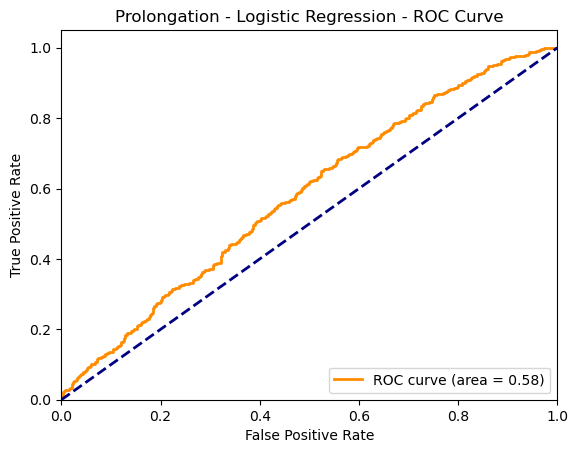

In [121]:
plot_roc(best_model_lr, 'Logistic Regression')

In [122]:
file_path = "LogisticRegression_Prolongation.pkl"

with open(file_path, 'wb') as file:
    pickle.dump(best_model_nb, file)

In [123]:
verifyer_lr = pd.DataFrame([X_test, y_pred_lr, y_test]).T
verifyer_lr.columns = ['audio', 'y_pred', 'y_test']
verifyer_lr.to_csv("predicted_lr_prolongation.csv")
test_lr = pd.DataFrame([X_test, y_test, y_pred_lr]).T
test_lr.columns = ['X_test', 'y_test', 'y_pred']
test_lr.to_csv("test_lr_prolongation.csv")

# Comparitive Analysis

In [124]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [125]:
models = ['Random Forest', 'Decision Tree', 'KNN', 'SVC', 'Naive Bayes', 'Logistic Regression']
accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores = []
best_models = [best_model_rf, best_model_dt, best_model_knn, best_model_svc, best_model_nb, best_model_lr]
y_preds = [y_pred_rf, y_pred_dt, y_pred_knn, y_pred_svc, y_pred_nb, y_pred_lr]

In [126]:
# Function to calculate evaluation metrics
def calculate_metrics(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    return accuracy, precision, recall, f1

In [127]:
# Calculate evaluation metrics for each model
for model, y_pred in zip(best_models, y_preds):
    accuracy, precision, recall, f1 = calculate_metrics(y_test, y_pred)
    accuracy_scores.append(accuracy)
    precision_scores.append(precision)
    recall_scores.append(recall)
    f1_scores.append(f1)

In [128]:
evaluation_df = pd.DataFrame({
    'Model': models,
    'Accuracy': accuracy_scores,
    'Precision': precision_scores,
    'Recall': recall_scores,
    'F1 Score': f1_scores
})
print('Comparison of all ML models (Prolongation): ')
evaluation_df

Comparison of all ML models (Prolongation): 


,Model,Accuracy,Precision,Recall,F1 Score
0,Random Forest,0.657789,0.676951,0.602585,0.637607
1,Decision Tree,0.575464,0.596674,0.463651,0.521818
2,KNN,0.604520,0.601256,0.618740,0.609873
3,SVC,0.628733,0.623639,0.647819,0.635499
4,Naive Bayes,0.598063,0.600666,0.583199,0.591803
5,Logistic Regression,0.550444,0.548137,0.570275,0.558987


In [129]:
print(f'Highest Accuracy score of {np.max(accuracy_scores)*100:.2f}% with {models[np.argmax(accuracy_scores)]}')
print(f'Highest Precision score of {np.max(precision_scores)*100:.2f}% with {models[np.argmax(precision_scores)]}')
print(f'Highest Recall score of {np.max(recall_scores)*100:.2f}% with {models[np.argmax(recall_scores)]}')
print(f'Highest F1 score of {np.max(f1_scores)*100:.2f}% with {models[np.argmax(f1_scores)]}')

Highest Accuracy score of 65.78% with Random Forest
Highest Precision score of 67.70% with Random Forest
Highest Recall score of 64.78% with SVC
Highest F1 score of 63.76% with Random Forest
